In [7]:
# general
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


raw = pd.read_csv("Breast_GSE45827.csv")
raw.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,84,basal,9.850040,8.097927,6.424728,7.353027,3.029122,6.880079,4.963740,4.408328,...,12.229711,11.852955,13.658701,13.477698,6.265781,5.016196,4.901594,2.966657,3.508495,3.301999
1,85,basal,9.861357,8.212222,7.062593,7.685578,3.149468,7.542283,5.129607,4.584418,...,12.178531,11.809408,13.750086,13.470146,6.771853,5.291005,5.405839,2.934763,3.687666,3.064299
2,87,basal,10.103478,8.936137,5.735970,7.687822,3.125931,6.562369,4.813449,4.425195,...,12.125108,11.725766,13.621732,13.295080,6.346952,5.171403,5.184286,2.847684,3.550597,3.158535
3,90,basal,9.756875,7.357148,6.479183,6.986624,3.181638,7.802344,5.490982,4.567956,...,12.111235,11.719215,13.743108,13.508861,6.610284,5.193356,5.086569,3.031602,3.524981,3.272665
4,91,basal,9.408330,7.746404,6.693980,7.333426,3.169923,7.610457,5.372469,4.424426,...,12.173642,11.861296,13.797774,13.542206,6.414354,5.040202,5.235318,2.956232,3.445501,3.193947


## Pre-process

In [8]:
raw.value_counts('type')

type
basal        41
HER          30
luminal_B    30
luminal_A    29
cell_line    14
normal        7
Name: count, dtype: int64

In [9]:
df = raw.set_index('samples')
X = df.drop(columns={'type'},axis=1)
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)


In [ ]:
# 2. Define the random forest model and parameter grid
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}#

# 3. Perform grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# 4. Evaluate best model on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred))

# 5. Get feature importances
importances = best_rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Subset to top 20 features
top_n = 20
top_features = importance_df.head(top_n)

print(f"\nTop {top_n} Feature Importances:\n", top_features)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report on Test Set:
               precision    recall  f1-score   support

         HER       0.86      1.00      0.92         6
       basal       1.00      0.88      0.93         8
   cell_line       1.00      1.00      1.00         3
   luminal_A       0.83      0.83      0.83         6
   luminal_B       0.86      1.00      0.92         6
      normal       1.00      0.50      0.67         2

    accuracy                           0.90        31
   macro avg       0.92      0.87      0.88        31
weighted avg       0.91      0.90      0.90        31


Top 20 Feature Importances:
                        Feature  Importance
19457              210052_s_at    0.002384
14561              205114_s_at    0.001991
54483                 52940_at    0.001769
37527                228273_

In [11]:
# Rename the Feature column to 'ID'
importance_df = importance_df.rename(columns={"Feature": "ID"})

# Ensure 'ID' column in importance_df is string
importance_df["ID"] = importance_df["ID"].astype(str)

# Load the annotation file
gpl = pd.read_csv("GPL570-55999.txt", sep='\t', comment='#', low_memory=False)

# Subset columns we care about and ensure 'ID' is string
annotation = gpl[['ID', 'Gene Symbol','Gene Ontology Molecular Function']].dropna()
annotation["ID"] = annotation["ID"].astype(str)

# Merge using string-typed IDs
importance_df_anno = importance_df.merge(annotation, on='ID', how='left')

importance_df_anno = importance_df_anno.dropna(subset=['Gene Symbol'])

# Convert gene symbols to string (in case some are still floats)
importance_df_anno['Gene Symbol'] = importance_df_anno['Gene Symbol'].astype(str)

importance_df_anno['Gene Ontology Molecular Function'] = importance_df_anno['Gene Ontology Molecular Function'].astype(str).str[:60]

# Display result
importance_df_anno.head()

,ID,Importance,Gene Symbol,Gene Ontology Molecular Function
0,210052_s_at,0.002384,TPX2,0005515 // protein binding // inferred from ph...
1,205114_s_at,0.001991,CCL3 /// CCL3L1 /// CCL3L3,0004672 // protein kinase activity // inferred...
2,52940_at,0.001769,SIGIRR,0005515 // protein binding // inferred from ph...
4,224909_s_at,0.001617,PREX1,0005085 // guanyl-nucleotide exchange factor a...
5,208305_at,0.001409,PGR,0000978 // RNA polymerase II core promoter pro...


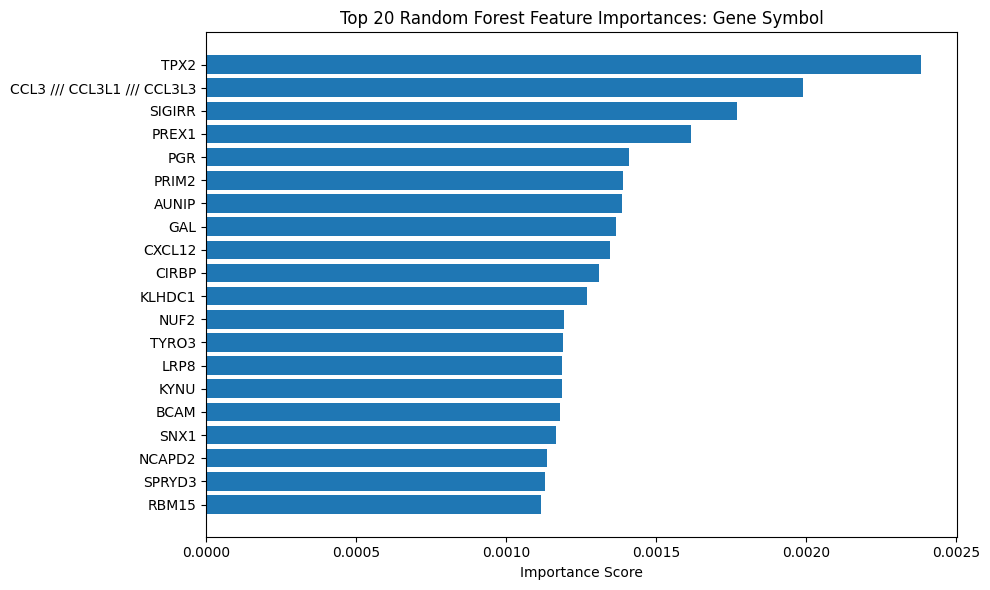

In [12]:
# Optional: limit to top N
top_n = 20
importance_df_anno = importance_df_anno.sort_values(by='Importance', ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df_anno['Gene Symbol'], importance_df_anno['Importance'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Random Forest Feature Importances: Gene Symbol')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



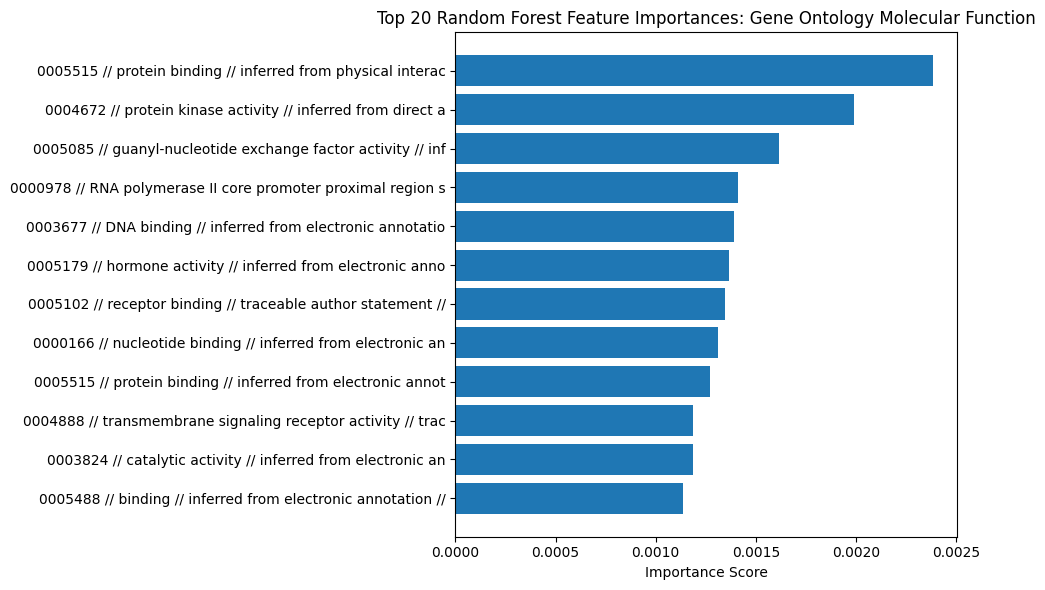

In [13]:
# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df_anno['Gene Ontology Molecular Function'], importance_df_anno['Importance'])
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Random Forest Feature Importances: Gene Ontology Molecular Function')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
# Garrett want us to maybe explain what the highest feature importance genes mean? Like what the function of the genes are.